![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Airline Buybacks
---------
### Introduction
This notebook explains how to you can use the Research Environment to develop and test a Airline Buybacks hypothesis, then put the hypothesis in production.

<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/airline-buybacks">Documentation</a>

### Create Hypothesis
Buyback represents a company buy back its own stocks in the market, as (1) management is confident on its own future, and (2) wants more control over its development. Since usually buyback is in large scale on a schedule, the price of repurchasing is often higher than that of the market price (demand > supply). Another way of thought is that, the liquid stock outstanding is reduced. Thus, the price of the stock is expeceted to increase if these conditions stand.

Airlines is one of the largest buyback sectors. Major US Airlines use over 90% of their free cashflow to buy back their own stocks in the recent years.<sup><a href="https://www.bloomberg.com/news/articles/2020-03-16/u-s-airlines-spent-96-of-free-cash-flow-on-buybacks-chart">[1]</a></sup> Therefore, we can use airline companies to test the hypothesis of buybacks result in price increase, since they have more data to regress. In this particular exmaple, we're hypothesizing that if the buyback price is larger than the previous close price, then the active return for the next day will be positive.

### Prerequisites
We'll need to use the <a href="https://www.quantconnect.com/datasets/smart-insider-corporate-buybacks/pricing/">Smart Insider Corporate Buybacks Transaction</a> dataset in this tutorial, you must subscribe to this dataset to get this data.

If you use Python, you must understand how to work with pandas DataFrames and Series. If you are not familiar with pandas, refer to the <a href="https://pandas.pydata.org/docs/">pandas documentation</a>.

### Import Packages
We'll need to import packages to help with data processing, validationa and visualization. Import SmartInsiderTransaction, statsmodels, sklearn, numpy, pandas and seaborn packages by the following:

In [1]:
from QuantConnect.DataSource import SmartInsiderTransaction

from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

### Get Historical Data
To begin, we retrieve historical data for research.

In [2]:
# Instantiate a QuantBook.
qb = QuantBook()

# Select the airline tickers for research.
symbols = {}
assets = ["LUV",   # Southwest Airlines
          "DAL",   # Delta Airlines
          "UAL",   # United Airlines Holdings
          "AAL",   # American Airlines Group
          "SKYW",  # SkyWest Inc. 
          "ALGT",  # Allegiant Travel Co.
          "ALK"    # Alaska Air Group Inc.
         ]

# Call the AddEquity method with the tickers, and its corresponding resolution. Then call AddData with SmartInsiderTransaction to subscribe to their buyback transaction data.
for ticker in assets:
    symbol = qb.AddEquity(ticker, Resolution.Minute).Symbol
    symbols[symbol] = qb.AddData(SmartInsiderTransaction, symbol).Symbol

# Call the History method with list of tickers, time argument(s), and resolution to request historical data for the symbol.
history = qb.History(list(symbols.keys()), datetime(2015, 1, 1), datetime(2022, 1, 1), Resolution.Daily)

# Call SPY history as reference
spy = qb.History(qb.AddEquity("SPY").Symbol, datetime(2015, 1, 1), datetime(2022, 1, 1), Resolution.Daily)

# Call the History method with list of buyback tickers, time argument(s), and resolution to request buyback data for the symbol.
history_buybacks = qb.History(list(symbols.values()), datetime(2015, 1, 1), datetime(2022, 1, 1), Resolution.Daily)
history_buybacks

amount  \
symbol                                    time                             
DAL.SmartInsiderTransaction TSAT9G6HOJ8K  2015-04-16 05:47:53  4904799.0   
                                          2015-04-16 05:48:47  4352139.0   
                                          2015-07-16 06:37:34  4848658.0   
                                          2015-07-16 06:38:00  8505352.0   
                                          2015-07-16 06:38:24  7722856.0   
...                                                                  ...   
SKYW.SmartInsiderTransaction R735QTJ8XC9W 2019-11-07 06:49:15   111584.0   
                                          2020-02-19 07:16:26    87632.0   
                                          2020-02-19 07:39:11    79749.0   
                                          2020-05-09 09:51:18   268391.0   
                                          2020-05-09 09:51:47   117215.0   

                                                              announcedin  \
symbol                                    time                              
DAL.SmartInsiderTransaction TSAT9G6HOJ8K  2015-04-16 05:47:53          US   
                                          2015-04-16 05:48:47          US   
                                          2015-07-16 06:37:34          US   
                                          2015-07-16 06:38:00          US   
                                          2015-07-16 06:38:24          US   
...                                                                   ...   
SKYW.SmartInsiderTransaction R735QTJ8XC9W 2019-11-07 06:49:15          US   
                                          2020-02-19 07:16:26          US   
                                          2020-02-19 07:39:11          US   
                                          2020-05-09 09:51:18          US   
                                          2020-05-09 09:51:47          US   

                                                              announcementdate  \
symbol                                    time                                   
DAL.SmartInsiderTransaction TSAT9G6HOJ8K  2015-04-16 05:47:53       2015-04-16   
                                          2015-04-16 05:48:47       2015-04-16   
                                          2015-07-16 06:37:34       2015-07-16   
                                          2015-07-16 06:38:00       2015-07-16   
                                          2015-07-16 06:38:24       2015-07-16   
...                                                                        ...   
SKYW.SmartInsiderTransaction R735QTJ8XC9W 2019-11-07 06:49:15       2019-11-07   
                                          2020-02-19 07:16:26       2020-02-19   
                                          2020-02-19 07:39:11       2020-02-19   
                                          2020-05-09 09:51:18       2020-05-09   
                                          2020-05-09 09:51:47       2020-05-09   

                                                              buybackdate  \
symbol                                    time                              
DAL.SmartInsiderTransaction TSAT9G6HOJ8K  2015-04-16 05:47:53  2015-02-28   
                                          2015-04-16 05:48:47  2015-03-31   
                                          2015-07-16 06:37:34  2015-04-30   
                                          2015-07-16 06:38:00  2015-05-31   
                                          2015-07-16 06:38:24  2015-06-30   
...                                                                   ...   
SKYW.SmartInsiderTransaction R735QTJ8XC9W 2019-11-07 06:49:15  2019-09-30   
                                          2020-02-19 07:16:26  2019-10-31   
                                          2020-02-19 07:39:11  2019-12-31   
                                          2020-05-09 09:51:18  2020-02-29   
                                          2020-05-09 09:51:47  2020-03-31   

      

### Preparing Data
We'll have to process our data to get the buyback volume% vs forward return data.

In [6]:
# Select the close column and then call the unstack method to get the close price dataframe.
df = history['close'].unstack(level=0)
spy_close = spy['close'].unstack(level=0)

# Call pct_change to get the daily return of close price, then shift 1-step backward as prediction.
ret = df.pct_change().shift(-1).iloc[:-1]
ret_spy = spy_close.pct_change().shift(-1).iloc[:-1]

# Get the active return
active_ret = ret.sub(ret_spy.values, axis=0)

# Select the ExecutionPrice column and then call the unstack method to get the dataframe.
df_buybacks = history_buybacks['executionprice'].unstack(level=0)

# Convert buyback history into daily mean data
df_buybacks = df_buybacks.groupby(df_buybacks.index.date).mean()
df_buybacks.columns = df.columns

# Get the buyback premium/discount
df_close = df.reindex(df_buybacks.index)[~df_buybacks.isna()]
df_buybacks = (df_buybacks - df_close)/df_close

# Create a dataframe to hold the buyback and 1-day forward return data
data = pd.DataFrame(columns=["Buybacks", "Return"])

# Append the data into the dataframe
for row, row_buyback in zip(active_ret.reindex(df_buybacks.index).itertuples(), df_buybacks.itertuples()):
    index = row[0]
    for i in range(1, df_buybacks.shape[1]+1):
        if row_buyback[i] != 0:
            data = pd.concat([data, pd.DataFrame({"Buybacks": row_buyback[i], "Return":row[i]}, index=[index])])

# Call dropna to drop NaNs
data.dropna(inplace=True)
data

,Buybacks,Return
2015-04-16,0.151494,0.018206
2015-04-24,0.004242,0.022312
2015-04-24,0.083015,0.009606
2015-05-01,-1.000000,0.039499
2015-05-07,0.189470,0.020018
...,...,...
2020-10-14,-0.122547,0.005969
2020-10-16,0.085450,-0.002023
2021-02-13,-0.162547,0.032282
2021-04-16,-0.105510,-0.007187


### Test the Hypothesis
We would test (1) if the 2 data's interaction is statistically significantly, and (2) buyback could suggest positive return.

Optimization terminated successfully.
         Current function value: 0.663599
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:                          Logit   Df Residuals:                      113
Method:                           MLE   Df Model:                            0
Date:                Sun, 09 Jan 2022   Pseudo R-squ.:                 0.04263
Time:                        09:22:57   Log-Likelihood:                -75.650
converged:                       True   LL-Null:                       -79.019
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.4018      0.623     -2.249      0.024      -2.623      -0.180
==============================================================================
"""

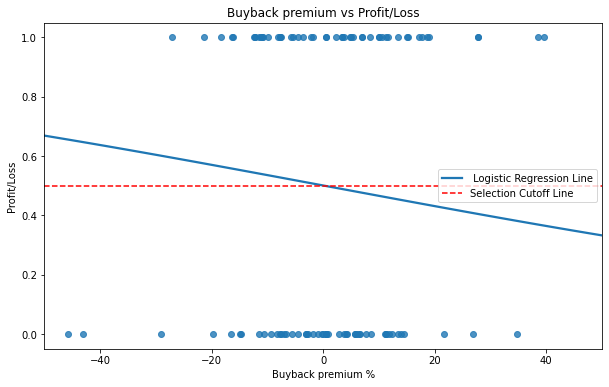

In [4]:
# Get binary return (+/-)
binary_ret = data[data > 0].fillna(0)[data < 0].fillna(1)["Return"]

# Construct a logistic regression model
model = Logit(binary_ret.values, data["Buybacks"].values).fit()

# Display results
display(model.summary())

# Plot the data
plt.figure(figsize=(10, 6))
sns.regplot(x=data["Buybacks"]*100, y=binary_ret, logistic=True, ci=None, line_kws={'label': " Logistic Regression Line"})
plt.plot([-50, 50], [0.5, 0.5], "r--", label="Selection Cutoff Line")
plt.title("Buyback premium vs Profit/Loss")
plt.xlabel("Buyback premium %")
plt.xlim([-50, 50])
plt.ylabel("Profit/Loss")
plt.legend()
plt.show()

We can see a p-value of < 0.05 in the logistic regression model, meaning the separation of positive and negative is statistically significant. Interesting, from the logistic regression line, we observe that when the airlines brought their stock in premium price, the price tended to go down, while the opposite for buying back in discount.

In [5]:
# Get in-sample prediction result.
predictions = model.predict(data["Buybacks"].values)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i] > 0.5 else 0

# Call confusion_matrix to contrast the results.
cm = confusion_matrix(binary_ret, predictions)

# Display the result.
df_result = pd.DataFrame(cm, 
                        index=pd.MultiIndex.from_tuples([("Prediction", "Positive"), ("Prediction", "Negative")]),
                        columns=pd.MultiIndex.from_tuples([("Actual", "Positive"), ("Actual", "Negative")]))
df_result 

Actual         
                    Positive Negative
Prediction Positive       32       25
           Negative       28       29

The logistic regression is having a 53.5% accuracy (53.3% sensitivity and 53.7% specificity), this can suggest a > 50% win rate, proven our hypothesis.

### Source

[1] US Airlines Spent 96% of Free Cash Flow on Buybacks: Chart. B. Kochkodin (17 March 2020). Bloomberg. Retrieve from: https://www.bloomberg.com/news/articles/2020-03-16/u-s-airlines-spent-96-of-free-cash-flow-on-buybacks-chart.